# Language Knowledge (Vocabulary)
Duration: 30 minutes
Content: This section tests your knowledge of Japanese vocabulary, including kanji readings, orthography, word formation, contextually-defined expressions, paraphrases, and usage
It mainly composes following five categories:
- ``Reading Kana`` (Pronunciation Questions): Given a kanji word, choose the correct kana reading.
- `Writing Kanji` (Writing Questions): Given a word written in kana, choose the correct kanji representation.
- `Word Meaning` Selection (Vocabulary Understanding): Choose the most suitable word to fill in the sentence from four options.
- `Synonym Replacement`: Select a word that has the same or similar meaning as the underlined word.
- `Vocabulary Usage`: Assess the usage of words in actual contexts, choosing the most appropriate word usage, including some common Japanese expressions or fixed phrases.

In [80]:
import pandas as pd
import json
import os
import random
import pickle
import re
import uuid
from typing import *
from langchain_openai import AzureOpenAI,AzureChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from dotenv import load_dotenv
from langchain_aws import ChatBedrock
from langchain.embeddings.base import Embeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.embeddings import HuggingFaceEmbeddings
# from langchain_community.embeddings import XinferenceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from IPython.display import display, Markdown, Latex
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage,RemoveMessage,HumanMessage,AIMessage,ToolMessage
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import List, Optional
from langchain_tavily import TavilySearch
from langchain.schema import Document
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults

load_dotenv()

True

In [81]:
# Import N3 Vocabulary
file_path = '../Vocab/n3.csv'
# Read the CSV file
data = pd.read_csv(file_path)
words = data.iloc[:, :2].sample(frac=1).reset_index(drop=True)
# Display the content of the CSV file
words.head()
vocab_dict = words.set_index(words.columns[0])[words.columns[1]].to_dict()
vocab_dict = json.dumps(vocab_dict, ensure_ascii=False, separators=(',', ':'))

#### load Models

In [82]:
azure_llm = AzureChatOpenAI(
    azure_endpoint="https://tooldev-openai.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview",
    api_key=os.environ["AZURE_API_KEY"],
    model_name="gpt-4o",
    api_version="2025-01-01-preview",
    temperature=0.5,
)

In [83]:
aws_llm = ChatBedrock(
    # model_id="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
     model_id="us.anthropic.claude-3-5-haiku-20241022-v1:0",
    model_kwargs=dict(temperature=0.5),
    region = "us-east-2",
    aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
    aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
)

In [84]:
res = aws_llm.invoke(input=[HumanMessage(content="hello，今天是几号？")])
res.content

'很抱歉,我无法获知今天的具体日期。作为AI助手,我没有实时的日历信息。您可以查看设备的日历或时钟来确定今天的具体日期。'

#### Exam Paper Outline
### A. overall thinking the structure of an exam
1. distribution of the difficulty 
2. topics
3. reasoning

## Data Strcuture

# Kanji 读假名（读音问题）

In [85]:
def online_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    
    print("---WEB SEARCH---")
    
    topic = state['messages'][0].content
    
    tavily_search_tool = TavilySearch(
        max_results=5,
        topic="general",
        time_range="day",
    )
    # Web search
    docs = tavily_search_tool.invoke({"query": topic})
    
    print(docs)

    web_results = "\n".join([d["content"] for d in docs["results"]])
    
    print("Web results: ", web_results)

    return {"documents": web_results, "topic": topic}

In [86]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class QuestionState(TypedDict):
    topic: str
    question: str
    documents: str
    messages: Annotated[list, add_messages]


kanji_example = """
1) いま 店の まえにいます。
1 いえ
2 えき
3 みせ
4 へや
2) たなかさんは いま 外国に います。
1 がいしゃ
2 かいしゃ
3 かいこく 4 がいこく
3) さとうさんは 話が じょうずです。
1 うた
2 はなし
3 え
4 じ
4) はやしさんも 読んで ください。
1 あそんで
2 ならんで
3 よんで
4 えらんで
5) あたらしい こうえんは まちの 北がわに あります。
1 ひがしがわ
2 みなみがわ
3 にしがわ
4 きたがわ
6) わたしは 九月に けっこんします。。
1 くがつ
2 きゅうがつ
3 くげつ
4 きゅうげつ
7) きのう 来なかった ひとは だれですか。
1 きなかった
2 こなかった
3 いなかった 
4 ねなかった
"""

# Nodes
def question_draft_generator(state: QuestionState):
    """First LLM call to generate initial question"""
    print("---Generator----")
        
    search_result = state['documents'],
    
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """
                    You are a Japanese teacher. Your job is to write 1 vocabulary question for Kanji reading of a JLPT N3 level exam paper with the `Search result`.
                    If the user provides critique, respond with a revised version of your previous attempts.
                    The chosen topic is {topic}.
                    This question requests recognizing kanji in context, such as in sentences or phrases. 
                    Don't replace the kanji part of the word but only substitute the rest part of the word in the options.
                    The vocabulary should be restricted to N3 level, use the vocabulary in the `Dictionary` as much as you can.
                    Please refer to the question examples following the formal exam paper. please highlight the kanji with <u><em></em></u>.
                    Append the correct answer and explanation of the main challenges on why the teacher asks this question to the candidate in Chinese at each question.
                    Finally, output beautiful markdown format.
                    Dictionary: {vocab_dict}
                    Search result: {search_result}
                    Formal exam paper: {kanji_example}
                """
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    
    input = { "topic" : state['topic'],
              "search_result": search_result, 
              "vocab_dict": vocab_dict,
              "kanji_example": kanji_example,
              "messages": state["messages"]
              }
    # final_message = prompt.format_messages(**input)
    # print(final_message)
    
    generate = prompt | aws_llm
    
    msg = generate.invoke(input=input)
    
    
    return {"question": msg.content, "messages": [AIMessage(content=msg.content)] }


def reflection_node(state: QuestionState) -> QuestionState:
    print("---REVISOR---")
    
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]

    reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """you are a Japanese language educator reviewing a JLPT example paper. Generate critique and recommendations for the user's submission.
            the review focuses on content accuracy and question quality. 
            - For content accuracy, you must verify that the grammar and vocabulary questions accurately reflect the appropriate JLPT N3 level, ensuring the reading passages are clear, relevant, and appropriately challenging. 
            - For question quality, you must ensure all questions are clearly worded and free from ambiguity to comprehensively assess different language skills, and confirm that the difficulty level of the questions matches the intended JLPT N3 level.
            - During detailed refinement, you check the format and presentation of the paper, ensuring it is well-organized and the instructions are clear and concise. you also ensure the content is culturally appropriate and relevant to Japanese language and culture.
            - Finally, you make give feedback, providing detailed recommendations, including requests.
            """
        ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    reflect = reflection_prompt | azure_llm
    
    res = reflect.invoke(translated)
    
    print(res.content)
    
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=res.content)]}



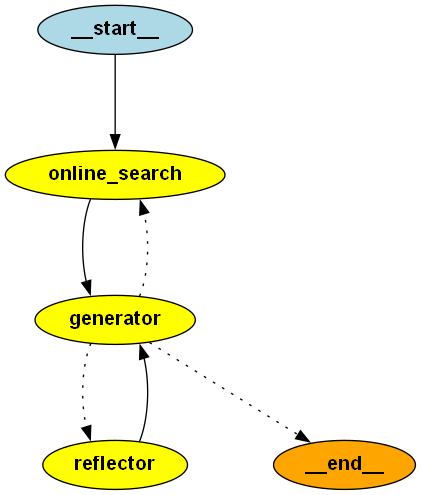

In [87]:
# Build workflow
builder = StateGraph(QuestionState)

builder.add_node("online_search", online_search)
builder.add_node("generator", question_draft_generator)
builder.add_node("reflector", reflection_node)
# Add nodes

def should_continue(state: QuestionState):
    if len(state["messages"]) > 2:
        # End after 3 iterations
        return END
    return "reflector"

# Add edges to connect nodes
builder.add_edge(START, "online_search")
builder.add_edge("online_search", "generator")
# 
builder.add_conditional_edges("generator", should_continue)
builder.add_edge("reflector", "generator")
memory = MemorySaver()

# Compile
kanji_graph = builder.compile(checkpointer=memory)

# Show workflow
display(Image(kanji_graph.get_graph().draw_png()))

In [88]:
row = words.iloc[1]
word = f"{row[0]}({row[1]})"
word

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22372\878816679.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  word = f"{row[0]}({row[1]})"


'委員(いいん)'

In [89]:
# Invoke
config = {"configurable": {"thread_id": "1"}}

# Debug the Conversation
for event in kanji_graph.stream(
    {
        "messages": [
            HumanMessage(
                content=word
            )
        ],
    },
    config,
):
    print(event)
    print("---")

---WEB SEARCH---
{'query': '委員(いいん)', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': '至急お願いします。 - 私のグラスには学級委員があります。そのことについ... - Yahoo!知恵袋', 'url': 'https://detail.chiebukuro.yahoo.co.jp/qa/question_detail/q11313451106', 'content': '私のグラスには学級委員があります。そのことについての投票があったのですが、選択肢が、学級委員をやりたい、やっても構わない、やりたくないでした。 ... 周りの子から一人暮らしの方が安いしいいんじゃないと言われるのですが全部含めたら家族と', 'score': 0.18988171, 'raw_content': None}, {'title': 'にじさんじ/コメントログ - アニヲタWiki(仮)【4/8更新】 - atwiki（アットウィキ）', 'url': 'https://w.atwiki.jp/aniwotawiki/pages/58579.html', 'content': 'とりあえず統合前後で分けるのがいいんじゃない？ -- 名無しさん (2023-08-18 16:48:50) 3Dのクオリティが高いよね -- 名無しさん (2023-11-08 14:10:01) ... 特に委員長・加賀美社長・サロメ嬢のわたくし族達は飛び抜けて好きだわ。 -- 名無しさん (2025-03-28 12:22:55) rfmo体', 'score': 0.11009767, 'raw_content': None}, {'title': '三森のアニキという名の仮面を被った男の告白｜三森のアニキ（うらの顔）', 'url': 'https://note.com/mimori_lb_note/n/na06938566535', 'content': '中学でも学級委員。常に誰かが周りにいる環境に慣れていたんです。今思えば、私は"中心"にいることに心地よさを感じていたのかもしれません。 ... それなら協力した方がいいんじゃないか？', 's

In [90]:
kanji = kanji_graph.invoke(
    {
       "messages": [
                HumanMessage(
                    content=word
                )
            ],
        },
    config
)
display(Markdown(kanji["question"]))

---WEB SEARCH---
{'query': '委員(いいん)', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': '至急お願いします。 - 私のグラスには学級委員があります。そのことについ... - Yahoo!知恵袋', 'url': 'https://detail.chiebukuro.yahoo.co.jp/qa/question_detail/q11313451106', 'content': '私のグラスには学級委員があります。そのことについての投票があったのですが、選択肢が、学級委員をやりたい、やっても構わない、やりたくないでした。 ... 周りの子から一人暮らしの方が安いしいいんじゃないと言われるのですが全部含めたら家族と', 'score': 0.18988171, 'raw_content': None}, {'title': 'にじさんじ/コメントログ - アニヲタWiki(仮)【4/8更新】 - atwiki（アットウィキ）', 'url': 'https://w.atwiki.jp/aniwotawiki/pages/58579.html', 'content': 'とりあえず統合前後で分けるのがいいんじゃない？ -- 名無しさん (2023-08-18 16:48:50) 3Dのクオリティが高いよね -- 名無しさん (2023-11-08 14:10:01) ... 特に委員長・加賀美社長・サロメ嬢のわたくし族達は飛び抜けて好きだわ。 -- 名無しさん (2025-03-28 12:22:55) rfmo体', 'score': 0.11009767, 'raw_content': None}, {'title': '三森のアニキという名の仮面を被った男の告白｜三森のアニキ（うらの顔）', 'url': 'https://note.com/mimori_lb_note/n/na06938566535', 'content': '中学でも学級委員。常に誰かが周りにいる環境に慣れていたんです。今思えば、私は"中心"にいることに心地よさを感じていたのかもしれません。 ... それなら協力した方がいいんじゃないか？', 's

I'll create a refined JLPT N3 level vocabulary question focusing on 委員 (いいん):

**問題：次の文章の空欄に入る最も適切な言葉はどれですか。**

市民の意見を聞くため、市長は新しい<u><em>委員</em></u>を立ち上げた。

1. 会議
2. 審査
3. 検討
4. 委員会

**正解：4 委員会**

**解説（中文）：**
這道題目測試考生對「委員」一詞在公共場合的理解和使用。「委員会」是一個常見的詞組，指由特定成員組成的委員會或審議機構。這個問題要求考生根據上下文選擇最合適的詞語，考察了語境中詞語的運用能力。

**Explanation in English:**
The question tests the candidate's understanding of the term 委員 (いいん, committee member) in a public context. 委員会 (いいんかい, committee) is a common term referring to a group of appointed members who discuss or investigate a specific issue.

**Cultural Context:**
In Japan, 委員会 are frequently used in government, local administration, and organizations to gather diverse opinions, conduct investigations, or make collective decisions. This reflects the Japanese cultural value of consensus and collective deliberation.

**Linguistic Breakdown:**
- 委員 (いいん): committee member
- 委員会 (いいんかい): committee
- 会議 (かいぎ): meeting
- 審査 (しんさ): examination, screening
- 検討 (けんとう): consideration, examination

The question tests:
1. Contextual vocabulary understanding
2. Kanji comprehension
3. Nuanced word selection
4. Public administration terminology

Would you like me to elaborate on any aspect of the question?